In [1]:
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
import pandas as pd
import numpy as np
import os

import IPython.display as display

# from PIL import Image

import tensorflow as tf

import tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, GlobalMaxPooling2D

from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
def append_extension(fn):
    return (fn+".jpg").zfill(7)

DATADIR = r"./adult" 
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(
    CSV_PATH,
    sheet_name=0,
)[["GreenID", "Grade"]].dropna(axis=0, subset=['Grade'])
response.Grade = response.Grade.astype('int')
response.GreenID = response.GreenID.astype('str').apply(append_extension)
response = response[response.Grade != 99]

data_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode='reflect',
    horizontal_flip=True,
#     vertical_flip=True,
    validation_split=0.1,
    rescale=1. / 255.,
#     preprocessing_function = preprocess_input
    zoom_range = 0.1
)

train_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    y_col="Grade",
    target_size=(224,224),
    color_mode='rgb',
    class_mode='raw',
    subset = "training",
    shuffle=True,
#     class_mode = "sparse"
)

validation_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    y_col="Grade",
    target_size=(224,224),
    color_mode='rgb',
    class_mode='raw',
    subset = "validation",
    shuffle=True,
#     class_mode = "sparse"
)

base_model = DenseNet121(include_top=False, weights="imagenet", classes=5, input_shape=(224,224,3))

for layer in base_model.layers[:301]:
    layer.trainable = False

Found 507 validated image filenames.
Found 56 validated image filenames.


C:\Users\feroc\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [3]:
x = base_model.output

x = Conv2D(64, (3, 3), strides = 1, activation="linear", bias_initializer=tf.keras.initializers.Constant(value=0))(x)
# x = Flatten()(x)

x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation="sigmoid",bias_initializer = tf.keras.initializers.Constant(value=0))(x)
preds = Dense(1, activation="linear", bias_initializer = tf.keras.initializers.Constant(value=4),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01),
             bias_constraint = tf.keras.constraints.MinMaxNorm(min_value=2, max_value=6, rate=1.0, axis=0))(x)
model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer="adam", loss='mean_squared_error', metrics=["mse"])

In [21]:
# model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [62]:
# def mean_pred(y_true, y_pred):
#     counts = tf.math.equal(y_true, y_pred).numpy()
#     return np.sum(counts)/len(counts)

In [4]:
model.fit_generator(generator=train_set,
                    epochs=300,
#                     verbose=2,
                    validation_data=validation_set,
#                     validation_freq=2,
                    )

Epoch 1/300
16/16 [==============================] - 8s 523ms/step - loss: 221.1614 - mse: 222.9556 - val_loss: 1667.0020 - val_mse: 1672.7977
Epoch 2/300
16/16 [==============================] - 7s 432ms/step - loss: 6.6727 - mse: 6.5540 - val_loss: 2181.9429 - val_mse: 2151.2642
Epoch 3/300
16/16 [==============================] - 7s 433ms/step - loss: 2.8860 - mse: 2.7846 - val_loss: 6.3764 - val_mse: 6.3525
Epoch 4/300
16/16 [==============================] - 7s 431ms/step - loss: 1.3442 - mse: 1.2366 - val_loss: 3.6987 - val_mse: 3.6152
Epoch 5/300
16/16 [==============================] - 7s 434ms/step - loss: 1.1281 - mse: 1.0244 - val_loss: 2.7870 - val_mse: 2.6859
Epoch 6/300
16/16 [==============================] - 7s 444ms/step - loss: 1.1095 - mse: 1.0061 - val_loss: 1.4875 - val_mse: 1.3567
Epoch 7/300
16/16 [==============================] - 7s 438ms/step - loss: 1.0427 - mse: 0.9369 - val_loss: 2.0466 - val_mse: 1.9716
Epoch 8/300
16/16 [==============================] - 

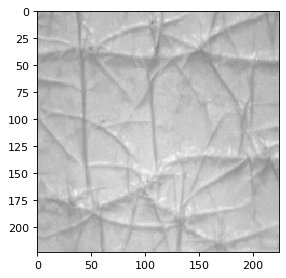

4


array([[1.8779483]], dtype=float32)

In [15]:
fig, ax = plt.subplots(dpi=80)
batch = next(train_set)
img = batch[0][0]
label = batch[1][0]
plt.imshow(img)
plt.show()
print(label)
model.predict(img.reshape(-1,224, 224, 3))